# Convolutional Neural Network - Gap / Char Classification
Using TensorFlow

Also need to convert images in folder into csv data file

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2

%matplotlib notebook

# Creating CSV
import glob
import csv

print("OpenCV: " + cv2.__version__)
print("Numpy: " + np.__version__)
print("TensorFlow: " + tf.__version__)

OpenCV: 3.1.0-dev
Numpy: 1.12.0
TensorFlow: 1.0.0-rc1


In [2]:
def implt(img, cmp=None, t=''):
    """ Show image using plt """
    plt.imshow(img, cmap=cmp)
    plt.title(t)
    plt.show()

## Load Images and Lables in CSV

In [3]:
# dimension 30x60 = 1800
# Or read_csv() form pandas
images = np.genfromtxt('data/gapdet/data.csv', delimiter=',')
labels = np.genfromtxt('data/gapdet/labels.csv', delimiter=',')
labels = np.reshape(labels, (len(labels), 1))

# Regularization of images
images = images.astype(np.float32)
images = np.multiply(images, 1.0 / 255.0)

print("CSV data files loaded.")
print("Number of images: " + str(len(images)))

div = int(0.9 * len(images))

trainData = images[0:div]
trainLabels = labels[0:div]
evalData = images[div:]
evalLabels = labels[div:]
print("Training images: %g" % div)

CSV data files loaded.
Number of images: 10043
Training images: 9038


# Create classifier

In [4]:
def sofmaxLabels(lab):
    """ Transform data for sofmax classification """
    newLab = np.zeros((len(lab), 2), dtype=np.int8)
    for i in range(len(lab)):
        newLab[i][int(lab[i][0])] = 1
    return newLab

llabels = sofmaxLabels(labels)
trainLabels = llabels[0:div]
evalLabels = llabels[div:]

In [5]:
class TrainingPlot:
    trainLoss = []
    trainAcc = []
    validAcc = []
    testInterval = 0
    lossInterval = 0
    interval = 0
    ax1 = None
    ax2 = None
    fig = None
    
    def __init__(self, steps, testItr, lossItr):
        self.testInterval = testItr
        self.lossInterval = lossItr
        self.interval = steps
              
        self.fig, self.ax1 = plt.subplots()
        self.ax2 = self.ax1.twinx()
        self.ax1.set_autoscaley_on(True)
        plt.ion()
        
        self.updatePlot()
        
        self.ax1.set_xlabel('iteration')
        self.ax1.set_ylabel('train loss')
        self.ax2.set_ylabel('test accuracy')

        
    def updatePlot(self):        
        self.fig.canvas.draw()

        
    def updateLoss(self, lossTrain, index):
        # Threshold the first loss addition - better graph scale
        if len(trainLoss) == 0 and lossTrain > 2:
            lossTrain = 2
            
        self.trainLoss.append(lossTrain)        
        self.ax1.plot(self.lossInterval * np.arange(len(self.trainLoss)), self.trainLoss, 'b')
        
        self.updatePlot()
        
    def updateAcc(self, accVal, accTrain, index):
        self.validAcc.append(accVal)
        self.trainAcc.append(accTrain)
                
        self.ax2.plot(self.testInterval * np.arange(len(self.validAcc)), self.validAcc, 'r')
        self.ax2.plot(self.testInterval * np.arange(len(self.trainAcc)), self.trainAcc, 'g')
        
        self.ax2.set_title('Valid. Accuracy: {:.4f}'.format(self.validAcc[-1]))
        
        self.updatePlot()
    
    
    

### Dataset

In [6]:
class DataSet:
    images = None
    labels = None
    length = 0
    index = 0

    def __init__(self, img, lbl):
        """ Crate the dataset """

#         img = img.astype(np.float32)
#         img = np.multiply(img, 1.0 / 255.0)

        self.images = img
        self.labels = lbl
        self.length = len(img)
        self.index = 0

    def next_batch(self, batchSize):
        """Return the next batch from the data set."""
        start = self.index
        self.index += batchSize
        
        if self.index > self.length:
            # Shuffle the data
            perm = np.arange(self.length)
            np.random.shuffle(perm)
            self.images = self.images[perm]
            self.labels = self.labels[perm]
            # Start next epoch
            start = 0
            self.index = batchSize
        

        end = self.index
        return self.images[start:end], self.labels[start:end]

In [7]:
trainSet = DataSet(trainData, trainLabels)

### Convulation Neural Network

In [8]:
def batch_norm(x, n_out, phase_train):
    """
    Batch normalization on convolutional maps.
    Ref.: http://stackoverflow.com/questions/33949786/how-could-i-use-batch-normalization-in-tensorflow
    Args:
        x:           Tensor, 4D BHWD input maps
        n_out:       integer, depth of input maps
        phase_train: boolean tf.Varialbe, true indicates training phase
        scope:       string, variable scope
    Return:
        normed:      batch-normalized maps
    """
    with tf.variable_scope('bn'):
        beta = tf.Variable(tf.constant(0.0, shape=[n_out]),
                                     name='beta', trainable=True)
        gamma = tf.Variable(tf.constant(1.0, shape=[n_out]),
                                      name='gamma', trainable=True)
        batch_mean, batch_var = tf.nn.moments(x, [0], name='moments')
        ema = tf.train.ExponentialMovingAverage(decay=0.5)

        def mean_var_with_update():
            ema_apply_op = ema.apply([batch_mean, batch_var])
            with tf.control_dependencies([ema_apply_op]):
                return tf.identity(batch_mean), tf.identity(batch_var)

        mean, var = tf.cond(phase_train,
                            mean_var_with_update,
                            lambda: (ema.average(batch_mean), ema.average(batch_var)))
        normed = tf.nn.batch_normalization(x, mean, var, beta, gamma, 1e-3)
    return normed

<IPython.core.display.Javascript object>


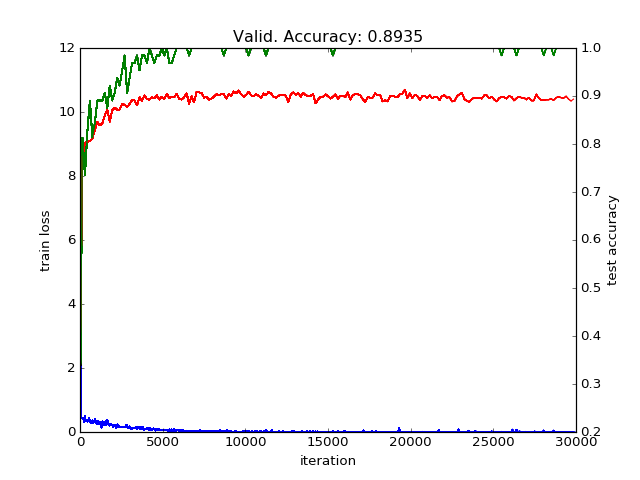

Eval accuracy 0.888557


In [9]:
sess = tf.InteractiveSession()

x = tf.placeholder(tf.float32, [None, 1800])
y_ = tf.placeholder(tf.float32, [None, 2])
phase_train = tf.placeholder(tf.bool, name='phase_train')

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')


x_image = tf.reshape(x, [-1, 30, 60, 1])

# 1. Layer - Convulation + Subsampling
W_conv1 = tf.Variable(tf.truncated_normal([5, 5, 1, 20], stddev=0.1), name="W_conv1")
b_conv1 = tf.Variable(tf.constant(0.1, shape=[20]), name="b_conv1")

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)

# 2. Layer - Max Pool
h_pool1 = max_pool_2x2(h_conv1)

# 3. Layer - Convulation + Subsampling
W_conv2 = tf.Variable(tf.truncated_normal([5, 5, 20, 50], stddev=0.1), name="W_conv2")
b_conv2 = tf.Variable(tf.constant(0.1, shape=[50]), name="b_conv2")

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)

# 4. Layer - Max Pool
h_pool2 = max_pool_2x2(h_conv2)

# # 3. Layer - Convulation
# W_conv3 = tf.Variable(tf.truncated_normal([5, 5, 16, 120], stddev=0.1), name="W_conv3")
# b_conv3 = tf.Variable(tf.constant(0.1, shape=[120]), name="b_conv3")

# h_conv3 = tf.nn.relu(conv2d(h_pool2, W_conv3) + b_conv3)

# Connected layer
W_fc1 = tf.Variable(tf.truncated_normal([8*15*50, 500], stddev=0.1), name="W_fc1")
b_fc1 = tf.Variable(tf.constant(0.1, shape=[500]), name="b_fc1")

h_conv3_flat = tf.reshape(h_pool2, [-1, 8*15*50])
h_fc1 = tf.nn.relu(tf.matmul(h_conv3_flat, W_fc1) + b_fc1)

# Dropout
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)


# Output layer
W_fc3 = tf.Variable(tf.truncated_normal([500, 2], stddev=0.1), name="W_fc3")
b_fc3 = tf.Variable(tf.constant(0.1, shape=[2]), name="b_fc3")

y_conv = tf.matmul(h_fc1_drop, W_fc3) + b_fc3


# Loss function
# cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv + 1e-10))
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_conv, labels=y_))

# Regularization with L2 Regularization with decaying learning rate 
beta = 0.001
regularizers = tf.nn.l2_loss(W_fc3) + tf.nn.l2_loss(W_fc1)
loss = tf.reduce_mean(cross_entropy + beta * regularizers)

# Optimizer
train_step = tf.train.AdamOptimizer(1e-4).minimize(loss)
# train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy)

correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()

### SETTINGS  ###
TRAIN_STEPS = 30000
TEST_ITER = 150
COST_ITER = 50
BATCH_SIZE = 64

# Graph for live ploting
trainPlot = TrainingPlot(TRAIN_STEPS, TEST_ITER, COST_ITER)

for i in range(TRAIN_STEPS):
    trainBatch, labelBatch = trainSet.next_batch(BATCH_SIZE)

    
    if i%COST_ITER == 0:    
        cost = cross_entropy.eval(feed_dict={x: trainBatch, y_: labelBatch, keep_prob: 1.0})
        trainPlot.updateLoss(cost, i // COST_ITER)
    
    if i%TEST_ITER == 0:
        accEval = accuracy.eval(feed_dict={x: evalData, y_: evalLabels, keep_prob: 1.0})
        accTrain = accuracy.eval(feed_dict={x: trainBatch, y_: labelBatch, keep_prob: 1.0})
        trainPlot.updateAcc(accEval, accTrain, i // TEST_ITER)
        
    if i%2000 == 0:
        saver.save(sess, 'models/CNN-CG')
        saver.export_meta_graph('models/CNN-CG.meta')

    train_step.run(feed_dict={x: trainBatch, y_: labelBatch, keep_prob: 0.5})

saver.save(sess, 'models/CNN-CG')
saver.export_meta_graph('models/CNN-CG.meta')    

print("Eval accuracy %g" % accuracy.eval(feed_dict={x: evalData, y_: evalLabels, keep_prob: 1.0}))
# print("Total accuracy: %g" % accuracy.eval(feed_dict={x: images, y_: llabels, keep_prob: 1.0}))

sess.close()